In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LogisticRegression

### Load MATLAB datafiles

In [4]:
data = loadmat("data/ex3data1.mat")
type(data)

dict

In [5]:
data.keys()

dict_keys(['__version__', '__header__', 'X', 'y', '__globals__'])

In [6]:
weights = loadmat('data/ex3weights.mat')
weights.keys()

dict_keys(['__version__', '__header__', 'Theta1', 'Theta2', '__globals__'])

In [8]:
y = data['y']
# Add constant for bias / intercept
X = np.c_[np.ones((data['X'].shape[0], 1)), data['X']]
print("X: {} (with bias/intercept)".format(X.shape))
print("y: {}".format(y.shape))

X: (5000, 401) (with bias/intercept)
y: (5000, 1)


[3954 3325  281  872 1733 2122 3437 4593 3850 3804 3833 2802 2499 3148 4525
 2397 2968 1293 2902 4374]


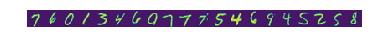

In [11]:
sample = np.random.choice(X.shape[0], 20)
#print(sample)
plt.imshow(X[sample, 1:].reshape(-1, 20).T)
plt.axis('off');

# Multi-class Classification

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [13]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#### Regularized Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [16]:
def regularized_logistic_regression(theta, reg, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1, 1)))
    
    J = - 1/m * (np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y)) + reg/2 * np.mean(np.sum(np.square(theta[1:])))
    
    if np.isnan(J.item()):
        return np.inf
    return J.item()

#### Partial derivative

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### Vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [17]:
def regularized_gradient(theta, reg, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1, 1)))
    
    gradient = 1/m * X.T.dot(h - y) + reg/m * np.r_[[[0]], theta[1:].reshape(-1, 1)]
    
    return gradient.flatten()

#### One - VS - All Classification

In [27]:
def one_vs_all(features, classes, n_labels, reg):
    initial_theta = np.zeros((X.shape[1], 1)) # 401 x 1
    all_theta = np.zeros((n_labels, X.shape[1])) # 10 X 401
    
    for label in range(1, n_labels+1):
        res = minimize(regularized_logistic_regression, initial_theta, args=(reg, features, (classes==label)*1), method=None,
                      jac=regularized_gradient, options={"maxiter": 100})
        all_theta[label-1] = res.x
    return all_theta

In [28]:
theta = one_vs_all(X, y, 10, 0.1)

#### One - VS - All Prediction

In [29]:
def predict(all_theta, features):
    probs = sigmoid(features.dot(all_theta.T))
    
    # Adding one because Python uses zero based indexing for the 10 columns
    return (np.argmax(probs, axis=1) + 1)

In [30]:
pred = predict(theta, X)
print("Training set accuracy: {}%".format(np.mean(pred==y.ravel())*100))    

Training set accuracy: 81.34%


#### Multi-class Logistic Regression with skit-learn

In [26]:
clf = LogisticRegression(C=10, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude the first column with 'ones' from X when fitting.
clf.fit(X[:, 1:], y.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
pred_sckit = clf.predict(X[:, 1:])
print("Training set accuracy: {}%".format(np.mean(pred_sckit==y.ravel())*100))

Training set accuracy: 96.5%


#### Multi-class Logistic Regression with Neural Networks

In [9]:
theta1, theta2 = weights['Theta1'], weights['Theta2']

print("theta1: {}".format(theta1.shape))
print("theta2: {}".format(theta2.shape))

theta1: (25, 401)
theta2: (10, 26)


In [40]:
def predict_neural(theta_1, theta_2, features):
    z1 = features.dot(theta1.T)
    a1 = np.c_[np.ones((data['X'].shape[0], 1)), sigmoid(z1)]
    
    z2 = a1.dot(theta_2.T)
    a2 = sigmoid(z2)
    
    return (np.argmax(a2, axis=1) + 1)

In [41]:
pred = predict_neural(theta1, theta2, X)
print("Training set accuracy: {}%".format(np.mean(pred==y.ravel())*100))

Training set accuracy: 97.52%
